# Classifying Self- vs. Other-Focused Content in r/schizophrenia Posts

## Table of Contents
1. [Introduction](#introduction)
1. [Step 1: Import data](#step-one)
1. [Step 2: Label data using regular expressions](#step-two)
1. [Step 3: Prepare data for modeling](#step-three)
1. [Step 4: Try some basic classifiers](#step-four)
    * [Random Forest](#rf)
    * [Support Vector Machine](#svm)
1. [Step 5: Classificaton with DistilBERT](#step-five)
1. [Step 6: Visualizing model generalizeability & performanceResults Visually](#step-six)
1. [Conclusions](#conclusions)
1. [References](#refs)


## Introduction <a name="introduction"></a>

* Natural language processing (NLP) methods can help us understand the behavior and thought patterns of people with neuropsychiatric disorders.

* Reddit forums specific to different disorders (e.g., r/depression, r/schizophrenia) provide large amounts of language data for free.

* A key challenge: determining which forum posts are focused on the poster's own symptoms or experiences (self-focused) and which are seeking advice or support for others (other-focused).   

* Here, I train and evaluate several classifiers for categorizing self- vs. other-focus in r/schizophrenia posts:

   - A Support Vector Machine (SVM) and a Random Forest model using a variety of linguistic features as predictors
   - A fine-tuned DistilBERT model trained on raw text data

### Data
* Subset of the Reddit Mental Health dataset collected by Low et al. (2020)
   - Contains text of Reddit posts from various mental health subreddits, from 2018-2020
   - Includes nearly 300 different linguistic features (e.g., readability, Linguistic Inquiry Word Count data, tf-idf vectors)
* For this project, used only posts from r/schizophrenia
* **Automatically-Labeled Subset:** Used regular expressions (see [below](#step-two)) to automatically label a subset of posts for training and testing (weak ground-truth) 
* **Manually-Labeled Subset:** Manually labeled 500 randomly-selected posts for additional model testing (strong ground-truth)


In [1]:
%%capture

%pip install pandas;
%pip install numpy;
%pip install transformers;
%pip install matplotlib;
%pip install sklearn;
%pip install os;

## Step 1: Import data <a name="step-one"></a>

In [2]:
#Setup
import pandas as pd
import numpy as np
import re

#Load data from csv
df = pd.read_csv('schizophrenia_all_annot.csv', low_memory = False) 

## Step 2: Automatically label data using regular expressions<a name="step-two"></a>
In order to train supervised models, we need to label some data as self- or other-focused. I used regular expressions to identify clear examples of self-focused (label: "self") and other-focused (label: "other") posts. Posts which could not clearly be identified as self or other were marked as "unclear" and excluded from the dataset. 

In [3]:
#Define regex patterns that clearly indicate self-focused posts
self_patterns = [
    r"\bi (am|have( \balways)?( \bhad)?|had) (schizo(.*)|psycho(.*))\b", 
    r"\bi (was|am|have been) (diagnosed with)? (schizo(.*)|psycho(.*))\b",
    r"\bi( \bwas)?( \bhad)? develop(ed)?(ing)? (schizo(.*)|psycho(.*))\b",
    r"\bdiagnosed me with (schizo(.*)|psycho(.*))\b"
    r"\bas someone with (schizo(.*)|psycho(.*))\b",
    r"\bmy (schizophrenia|schizoaffective|psychosis)(?! (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend))\b",
    r"\bi (was|am|have been|had been) hospitalized\b",
    r"\bi (was|am|have been|had been) medicated\b",
    
]

#Define regex patterns that clearly indicate other-focused posts
other_patterns = [
    r"\bmy (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend) (has( \balways)?( \bhad)?|is|was|had) (schizo(.*)|psycho(.*))\b",
    r"\bmy (schizo(.*)|psycho(.*)) (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend)\b",
    r"\bmy (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend)( \bwas)?( \bhad)? develop(ed)?(ing)? (schizo(.*)|psycho(.*))\b",
    r"\bmy (schizo(.*)|psycho(.*))\b (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend)\b",
    r"\bmy (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend)'s (schizo(.*)|psycho(.*))\b",
    r"\btheir (diagnosis)? (of|was)? (schizo(.*)|psycho(.*))\b",
    r"\bmy (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend) (has been|was) diagnosed with (schizo(.*)|psycho(.*))\b",
    r"\bdiagnosed my (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend) with (schizo(.*)|psycho(.*))\b",
    r"\bmy (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend) (was|am|have been|had been) hospitalized\b",
    r"\bmy (mom|mother|dad|father|brother|sister|son|daughter|friend|partner|husband|wife|ex|(ex)*(-)*( )*boyfriend|(ex)*(-)*( )*girlfriend) (was|am|have been|had been) medicated\b"
]

#function to search posts for regular expressions defined above
def label_post(text):
    text = text.lower()
    if any(re.search(p, text) for p in self_patterns):
        return "self"
    elif any(re.search(p, text) for p in other_patterns):
        return "other"
    else:
        return "unclear"

df["auto_label"] = df["post"].apply(label_post) 

In [4]:
summary =  df.auto_label.value_counts().reset_index(name='Frequency').rename(columns={'index':'auto_cat'})
print(summary)

  auto_cat  Frequency
0  unclear       6465
1     self        548
2    other        149


My regular expressions were able to label about 700 posts (about 10% of the dataset) as either self-focused or other-focused, with the majority of those (~77%) being self-focused.

## Step 3: Prepare data for modeling <a name="step-three"></a>

In [5]:
#Setup
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay, auc


seed = 3713 #set a random seed for reproduceability

#Define our predictors and labels 
label_data = df.loc[df['auto_label'] != 'unclear'] #subset to only labeled posts

X = label_data[label_data.columns[5:-1]] #select linguistic variables 
Y = label_data['auto_label'] #select labels

#Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=seed
)

## Step 4: Try some basic classifiers <a name="step-four"></a>
I first wanted to try training a couple of basic models using the nearly 300 linguistic variables that are provided by the Reddit Mental Health dataset. These variables are all numeric, so no transformations need to be applied.

### Random Forest <a name="rf"></a>

In [6]:
%%capture

# Use grid search with 5-fold cross-validation to select optimal RF parameters
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10]
}

rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring = "f1_macro") #use f1_macro score, rather than accuracy, due to unbalanced data
rf_grid.fit(X_train, Y_train)

**Results**

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


Full Classification Report with Best Parameters: 
 
               precision    recall  f1-score   support

       other       1.00      0.23      0.38        30
        self       0.83      1.00      0.91       110

    accuracy                           0.84       140
   macro avg       0.91      0.62      0.64       140
weighted avg       0.86      0.84      0.79       140



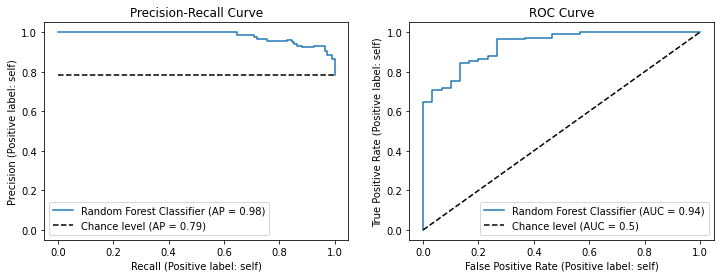

In [7]:
print("Best Parameters:", rf_grid.best_params_)
print("\n")
predictions = rf_grid.best_estimator_.predict(X_test)
print("Full Classification Report with Best Parameters: \n \n", classification_report(Y_test.tolist(), predictions))

#Plot Precision-Recall and ROC Curves
y_true = Y_test.tolist()
y_scores = [y[1] for y in rf_grid.best_estimator_.predict_proba(X_test)]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
PrecisionRecallDisplay.from_predictions(
    y_true = y_true,
    y_pred = y_scores,
    pos_label = "self",
    plot_chance_level = True,
    ax=ax1,           # The axes to plot on
    name="Random Forest Classifier" # Label for the legend
)

# Add title and labels
ax1.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Precision-Recall Curve"
)
RocCurveDisplay.from_predictions(
    y_true = y_true,
    y_pred = y_scores,
    pos_label = "self",
    plot_chance_level = True,
    ax=ax2,           # The axes to plot on
    name="Random Forest Classifier" # Label for the legend
)

# Add title and labels
ax2.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC Curve"
)
plt.show()

**Summary**<br>
Overall accuracy is relatively high (.84); however, our classes are heavily imbalanced, and we can see that this accuracy is primarily driven by performance in the "self" class. 
<br>
<br>
For a metric that accounts for performance in both classes equally, we can look at the macro average of the f1 score, which ranges from 0 (very poor performance) to 1 (very good performance). Our model achieves a score of .64, which is fairly mediocre. 
<br> 
<br>
Will a different classifier perform better? 


### Support Vector Machine <a name="svm"></a>

In [8]:
%%capture

# Use grid search with 5-fold cross-validation to select optimal SVM parameters
param_grid = {  
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}
svm_grid = GridSearchCV(SVC(), param_grid, refit = True, cv=5, scoring = "f1_macro") #use f1_macro score, rather than accuracy, due to unbalanced data
svm_grid.fit(X_train, Y_train)

**Results**

Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Full Classification Report with Best Parameters: 
 
               precision    recall  f1-score   support

       other       0.64      0.77      0.70        30
        self       0.93      0.88      0.91       110

    accuracy                           0.86       140
   macro avg       0.79      0.82      0.80       140
weighted avg       0.87      0.86      0.86       140



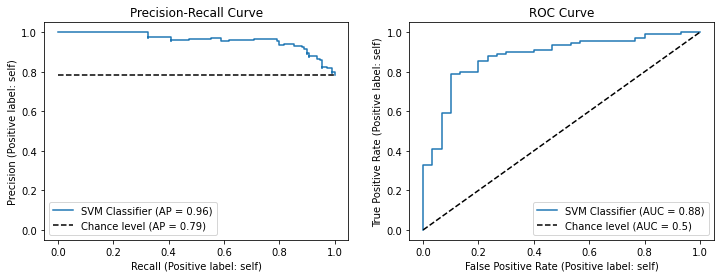

In [10]:
print("Best Parameters:", svm_grid.best_params_)
print("\n")
predictions = svm_grid.best_estimator_.predict(X_test)
print("Full Classification Report with Best Parameters: \n \n", classification_report(Y_test.tolist(), predictions))


#Plot Precision-Recall and ROC Curves
y_true = Y_test.tolist()
y_scores = svm_grid.best_estimator_.decision_function(X_test)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
PrecisionRecallDisplay.from_predictions(
    y_true = y_true,
    y_pred = y_scores,
    pos_label = "self",
    plot_chance_level = True,
    ax=ax1,           # The axes to plot on
    name="SVM Classifier" # Label for the legend
)

# Add title and labels
ax1.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Precision-Recall Curve"
)
RocCurveDisplay.from_predictions(
    y_true = y_true,
    y_pred = y_scores,
    pos_label = "self",
    plot_chance_level = True,
    ax=ax2,           # The axes to plot on
    name="SVM Classifier" # Label for the legend
)

# Add title and labels
ax2.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC Curve"
)
plt.show()

**Summary**<br>
Our SVM achieves an f1 score of .8, which is pretty good! Overall accuracy has improved a bit too, relative to the random forest model. 
<br>
<br>
This is a serviceable model, but we might be able to do still better by turning to LLMs. I'll next try fine-tuning a DistilBERT classifier. 

## Step 5: Classifying with DistilBERT <a name="step-five"></a>
The results of the SVM and Random Forest classifiers were mediocre. I wanted to see if I could do better with a more complex model - the LLM DistilBERT. Rather than relying on linguistic features, this allowed me to train the classifier on the raw text from the posts.

For simplicity, and because fine-tuning this model takes a long time, we won't use cross-validation here; however, to preserve as much data for training as possible, we will use our manually-labeled subset as the unseen test data. 


In [11]:
#Set up environment 

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, logging
logging.set_verbosity_error() #disable warnings

#Disable MPS (causes issues when using with Apple Silicon)
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
torch.backends.mps.enabled = False
torch.backends.mps.is_available = lambda: False
torch.backends.mps.is_built = lambda: False


import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [12]:
#Prepare for training

#separate out training vs. evaluation data
train_texts, eval_texts, train_labels, eval_labels = train_test_split(
    label_data["post"], label_data["auto_label"], test_size=0.2, random_state = seed)

#convert text labels to numeric
label_map = {"other": 0, "self": 1}

train_labels_num = train_labels.map(label_map)
eval_labels_num = eval_labels.map(label_map)

#convert post text to tokens
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
eval_encodings = tokenizer(list(eval_texts), truncation=True, padding=True)


#set up a dataset type to make feeding data to the model simpler
class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item
    def __len__(self):
        return len(self.labels)

#make datasets
train_dataset = RedditDataset(train_encodings, train_labels_num)
eval_dataset = RedditDataset(eval_encodings, eval_labels_num)


#set some params for training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    evaluation_strategy="epoch"
)

#make a function to compute f1 score and accuracy with evaluation dataset
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [13]:
#Fine-tune the model (or load fine-tuned model from saved)

if os.path.exists('./distilbert_self_vs_other.pt'):
    print("Loading fine-tuned model from saved...")
    model = AutoModelForSequenceClassification.from_pretrained('./distilbert_self_vs_other.pt')
    classifier = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )
else:
    print("Loading DistilBERT base model and fine-tuning...")
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
    classifier = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics = compute_metrics
    )
    classifier.train()
    classifier.save_model('./distilbert_self_vs_other.pt')
    

Loading fine-tuned model from saved...


**Results**

Full Classification Report: 
 
               precision    recall  f1-score   support

       other       0.97      0.97      0.97        30
        self       0.99      0.99      0.99       110

    accuracy                           0.99       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.99      0.99      0.99       140



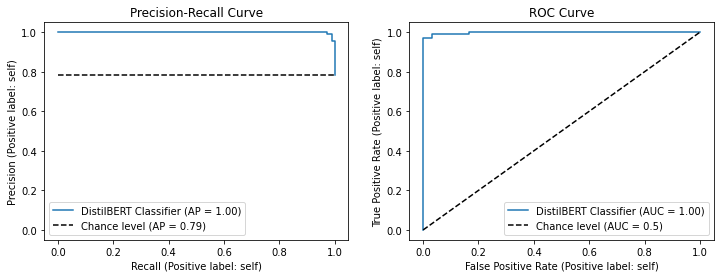

In [14]:
predicted = classifier.predict(eval_dataset)

#some transformation required to get probabilities from predictions
logits = predicted.predictions
logits_tensor = torch.tensor(logits)
label_map = {0: "other", 1: "self"}
predicted_ids = [label_map[i] for i in list(logits.argmax(axis=1))]


#print("\nClassification Report:\n", predicted.metrics)
print("Full Classification Report: \n \n", classification_report(eval_labels.tolist(), predicted_ids))

#Plot Precision-Recall and ROC Curves
y_true = eval_labels.tolist()


y_scores = [y[1] for y in F.softmax(logits_tensor, dim=1).numpy()]


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))
PrecisionRecallDisplay.from_predictions(
    y_true = y_true,
    y_pred = y_scores,
    pos_label = "self",
    plot_chance_level = True,
    ax=ax1,           # The axes to plot on
    name="DistilBERT Classifier" # Label for the legend
)


# Add title and labels
ax1.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Precision-Recall Curve"
)
RocCurveDisplay.from_predictions(
    y_true = y_true,
    y_pred = y_scores,
    pos_label = "self",
    plot_chance_level = True,
    ax=ax2,           # The axes to plot on
    name="DistilBERT Classifier" # Label for the legend
)

# Add title and labels
ax2.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC Curve"
)
plt.show()

**Summary**
<br>
The DistilBERT model achieved an overall accuracy of .99 and f1 score of .98, representing substantial improvement over the SVM classifier.


## Step 6: Comparing model generalizeability using a manually-labeled subset <a name="step-six"></a>
The vast majority of posts in the r/schizophrenia dataset could **not** be automatically labeled using regular expressions, as they did not contain explicit statements about the content of the post--whether it involves the poster's own diagnosis/symptoms (e.g., "I was diagnosed with schizophrenia") or someone else's (e.g., "my brother has schizophrenia"). 
<br>
<br>
Next, I examine whether the classifiers I trained are able to perform well even on posts which did not include these explicit statements.
<br>
<br>
I use the subset of posts that I manually labeled to test this. Filtering out the ones that were labeled automatically, this left me with a 463-post test set with which to compare my models. 



In [15]:
#prepare data for model testing

#separate out manually-labeled subset and exclude posts that could be labeled automatically
manual_subset = df.loc[(df['manual_label'].notnull()) & (df['auto_label'] == "unclear")] 

#separate predictors from labels
manual_X = manual_subset[manual_subset.columns[5:-1]] #select linguistic variables 
manual_Y = manual_subset['manual_label'] #select labels


#convert manual_subset into correct format for DistilBERT classification
label_map = {"other": 0, "self": 1}
manual_subset["manual_label_num"] = manual_subset["manual_label"].map(label_map) #convert text labels to numeric

manual_encodings = tokenizer(manual_subset['post'].tolist(), truncation=True, padding=True) #extract & tokenize text
manual_labels = manual_subset['manual_label_num'] #extract labels

manual_test = RedditDataset(manual_encodings, manual_labels) #construct dataset


Random Forest Classification Report with Best Parameters: 
 
               precision    recall  f1-score   support

       other       1.00      0.12      0.21        67
        self       0.87      1.00      0.93       395

    accuracy                           0.87       462
   macro avg       0.94      0.56      0.57       462
weighted avg       0.89      0.87      0.83       462

--------------------
SVM Classification Report: 
 
               precision    recall  f1-score   support

       other       0.46      0.46      0.46        67
        self       0.91      0.91      0.91       395

    accuracy                           0.84       462
   macro avg       0.69      0.69      0.69       462
weighted avg       0.84      0.84      0.84       462

--------------------

DistilBERT Classification Report:
               precision    recall  f1-score   support

       other       0.73      0.55      0.63        67
        self       0.93      0.96      0.95       395

    accurac

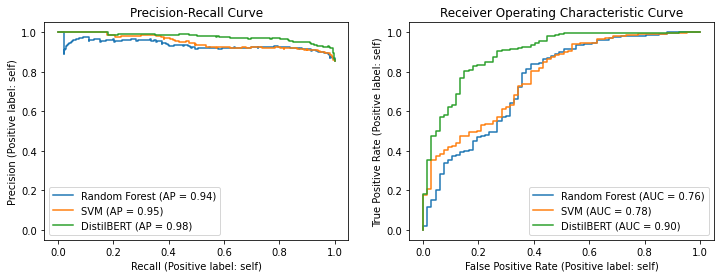

In [16]:
#Use models to generate predictions about test set

#Random forest
rf_predictions = rf_grid.best_estimator_.predict(manual_X) #predict
print("Random Forest Classification Report with Best Parameters: \n \n", classification_report(manual_Y.tolist(), rf_predictions)) 
print("--------------------")

#SVM
svm_predictions = svm_grid.best_estimator_.predict(manual_X) #predict
print("SVM Classification Report: \n \n", classification_report(manual_Y.tolist(), svm_predictions))
print("--------------------")


#DistilBERT
db_predicted = classifier.predict(manual_test) #predict based on manual subset

#some transformation required to get labels from predictions
db_logits = db_predicted.predictions
db_logits_tensor = torch.tensor(db_logits) # Convert to tensor

label_map = {0: "other", 1: "self"} #convert back to text labels
db_predicted_ids = [label_map[i] for i in db_logits.argmax(axis=1)] # Argmax logits to get labels
manual_labels_txt = [label_map[i] for i in manual_labels.tolist()] # Argmax logits to get labels


print("\nDistilBERT Classification Report:\n", classification_report(manual_labels_txt, db_predicted_ids))
print("--------------------")

#Plot Precision_Recall and ROC Curves
y_true = manual_Y.tolist()

rf_y_scores = [y[1] for y in rf_grid.best_estimator_.predict_proba(manual_X)]
svm_y_scores = svm_grid.best_estimator_.decision_function(manual_X)
db_y_scores =  [y[1] for y in F.softmax(db_logits_tensor, dim=1).numpy()]


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 4))


PrecisionRecallDisplay.from_predictions(
    y_true = y_true,
    y_pred = rf_y_scores,
    pos_label = "self",
    ax=ax1,           # The axes to plot on
    name="Random Forest" # Label for the legend
)

PrecisionRecallDisplay.from_predictions(
    y_true = y_true,
    y_pred = svm_y_scores,
    pos_label = "self",
    ax=ax1,           # The axes to plot on
    name="SVM" # Label for the legend
)

PrecisionRecallDisplay.from_predictions(
    y_true = y_true,
    y_pred = db_y_scores,
    pos_label = "self",
    ax=ax1,           # The axes to plot on
    name="DistilBERT" # Label for the legend
)
# Add title and labels
ax1.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Precision-Recall Curve"
)


RocCurveDisplay.from_predictions(
    y_true = y_true,
    y_pred = rf_y_scores,
    pos_label = "self",
    ax=ax2,           # The axes to plot on
    name="Random Forest" # Label for the legend
)

RocCurveDisplay.from_predictions(
    y_true = y_true,
    y_pred = svm_y_scores,
    pos_label = "self",
    ax=ax2,           # The axes to plot on
    name="SVM" # Label for the legend
)

RocCurveDisplay.from_predictions(
    y_true = y_true,
    y_pred = db_y_scores,
    pos_label = "self",
    ax=ax2,           # The axes to plot on
    name="DistilBERT" # Label for the legend
)

# Add title and labels
ax2.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver Operating Characteristic Curve"
)
plt.show()

## Conclusions <a name="conclusions"></a>

Unsurprisingly, all models performed somewhat worse on the manually-labeled subset, as none of these posts contained explicit statements about their content. However, DistilBERT substantially outperformed both the Random Forest and DistilBERT classifiers with an f1 macro average of .79 and overall accuracy of .9. 

Performance could likely be further improved by: (a) manually-labeling additional posts and fine-tuning the model on this data and/or (b) filtering out low-confidence predictions (e.g. < 90% probability of belonging to either class). 

## References <a name="refs"></a>
Low, D. M., Rumker, L., Torous, J., Cecchi, G., Ghosh, S. S., & Talkar, T. (2020). Natural Language Processing Reveals Vulnerable Mental Health Support Groups and Heightened Health Anxiety on Reddit During COVID-19: Observational Study. Journal of medical Internet research, 22(10), e22635.